## QC/EDA Notebook

12/04/2019

In [1]:
import os
import random
import re
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import matplotlib.colors as mplc
import subprocess


from scipy import signal

import plotly.figure_factory as ff
import plotly
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot 
import plotly.express as px
init_notebook_mode(connected = True)

In [2]:
from cycif_modules import *

## Functions

In [3]:
# This may change for each experiment, so I have not sequestered
# this code in the my_modules.py file

# This function takes in a dataframe, changes the names
# of the column in various ways, and returns the dataframe.
# For best accuracy and generalizability, the code uses
# regular expressions (regex) to find strings for replacement.
def apply_header_changes(df):
    # remove lowercase x at beginning of name
    df.columns = df.columns.str.replace("^x","")
    # remove space at beginning of name
    df.columns = df.columns.str.replace("^ ","")
    # replace space with underscore
    df.columns = df.columns.str.replace(" ","_")
    # fix typos
    df.columns = df.columns.str.replace("CKD1","CDK1")
    df.columns = df.columns.str.replace("GAG3","GATA3")
    return df

## Begin Workflow

In [4]:
not_intensities = ['Nuc_X', 'Nuc_X_Inv', 'Nuc_Y', 'Nuc_Y_Inv', 'Nucleus_Roundness',
       'Nucleus_Size','Cell_Size', 'ROI_index', 'Sample_ID', 'replicate_ID',
                  'Cell_ID','cell_type', 'cluster','ID']

Get directories - needs to be user-derived

In [5]:
## Comment for final workflow

ls_samples = ['TMA','ww1', 'ww10', 'ww11', 'ww12', 'ww13', 'ww15', 
              'ww16', 'ww17', 'ww19', 'ww2', 'ww20', 'ww21', 
              'ww22', 'ww23', 'ww3', 'ww4', 'ww5', 'ww6', 'ww7', 
              'ww8', 'ww9']#,'bad_header_file']

ls_samples = ['TMA1.1', 'TMA1.2', 'TMA1.3', 'TMA2.1', 'TMA2.2', 'TMA2.3']

ls_samples = ['GZ7.2', 'TMA', 'GZ10.3', 'GZ7.1', 'GZ10.2', 'GZ10.1', 'GZ6']

In [12]:
#set directory
## needs to be user iput

# Base directory for project
base_dir = '/Users/groutm/Desktop/weewin'
base_dir = '/Users/groutm/Desktop/reproducibility'

base_dir = 'Z:\Marilyne\Axioscan\Gao_Zhang\Segmentation'
base_dir = '/Users/groutm/Desktop/gz'

project_name = 'ww'
project_name = 'repro'
project_name = 'gz'
step_suffix = 'qc_eda'
previous_step_suffix_long = ""


# Initial input data directory
#input_data_dir = r'/Users/groutm/Desktop/TMAdata'
#input_data_dir = r'/Users/groutm/Desktop/ww_data'
input_data_dir = os.path.join(base_dir, project_name + "_data")
input_data_dir = base_dir

# QC/EDA directory
#output_data_dir = r'/Users/groutm/Desktop/TMAoutputdata'
#output_data_dir = r'/Users/groutm/Desktop/ww_outputdata'
output_data_dir = os.path.join(base_dir, project_name + "_" + step_suffix)

# QC/EDA images subdirectory
#output_images_dir = r'/Users/groutm/Desktop/TMAimages'
#output_images_dir = r'/Users/groutm/Desktop/wwimages'
output_images_dir = os.path.join(output_data_dir,"images")

# Metadata directories
metadata_dir = os.path.join(base_dir, project_name + "_metadata")
metadata_images_dir = os.path.join(metadata_dir,"images")

for d in [base_dir, input_data_dir, output_data_dir, output_images_dir, 
          metadata_dir, metadata_images_dir]:
    if not os.path.exists(d):
        os.makedirs(d)

os.chdir(input_data_dir)



Prompt user for any samples to remove from analysis

Prompt user for any files they would like excluded from analysis.

## Uncomment for final workflow

response = input("If there are any files you wish to exclude from analysis, \
                please enter them now in a comma-separated list \
                (e.g., 'sample001.csv, sample001.csv').\
                 Press ENTER to continue.").strip()
if response == "":
    print("\nNo files excluded.")
    
else:
    print("\nExcluding files: " + ", ".join([f for f in response.split(",")]) 
         + ".")
    
ls_samples = [f.replace(".csv","") for f in ls_samples if f not in response.split(",")]

print("\n Final file list for analysis: " + ", ".join([f for f in ls_samples]))


## Need to have QC checks here...

In [13]:
os.getcwd()

'/Users/groutm/Desktop/gz'

In [14]:
# Import all data files for this portion of workflow

# First gather information on expected headers using first file in ls_samples



# Read in the first row of the file correpsonding to the first sample (index = 0)
# in ls_samples
df = pd.read_csv(ls_samples[0] + 
                 previous_step_suffix_long + ".csv", index_col = 0, nrows = 1)

# Verify that the ID column in input file became the index
if df.index.name != "ID":
    print("Expected the first column in input file (index_col = 0) "
         "to be 'ID'. This column will be used to set the index names"
         "(cell number for each sample). It appears that the column '"
         + df.index.name + "' was actually the imported as the index "
         "column.")

# Apply the changes to the headers as specified in above funciton
df = apply_header_changes(df)

# Set variable to hold default header values
expected_headers = df.columns.values

In [15]:
df.index.name

'ID'

In [16]:
print("Used " + ls_samples[0] + ".csv to determine the expected, corrected headers for all files.")
print("There headers are: \n" + ", ".join([h for h in expected_headers]) + ".")

Used GZ7.2.csv to determine the expected, corrected headers for all files.
There headers are: 
Cell_Size, Nuc_X, Nuc_Y, Nucleus_Size, Nuc_Y_Inv, Nuc_X_Inv, ROI_index, DAPI_R7_Cell_Intensity_Average, DAPI_R7_Cytoplasm_Intensity_Average, DAPI_R7_Nucleus_Intensity_Average, AF488_Cell_Intensity_Average, AF488_Cytoplasm_Intensity_Average, AF488_Nucleus_Intensity_Average, AF555_Cell_Intensity_Average, AF555_Cytoplasm_Intensity_Average, AF555_Nucleus_Intensity_Average, AF647_Cell_Intensity_Average, AF647_Cytoplasm_Intensity_Average, AF647_Nucleus_Intensity_Average, AF750_Cell_Intensity_Average, AF750_Cytoplasm_Intensity_Average, AF750_Nucleus_Intensity_Average, DAPI_R1_Cell_Intensity_Average, DAPI_R1_Cytoplasm_Intensity_Average, DAPI_R1_Nucleus_Intensity_Average, H3K27me3_Cell_Intensity_Average, H3K27me3_Cytoplasm_Intensity_Average, H3K27me3_Nucleus_Intensity_Average, CCNA2_Cell_Intensity_Average, CCNA2_Cytoplasm_Intensity_Average, CCNA2_Nucleus_Intensity_Average, S100_Cell_Intensity_Average,

In [17]:
os.getcwd()

'/Users/groutm/Desktop/gz'

In [18]:
# Import all dfs

## TO-DO: include check that imported df is the expected size and shape...

dfs = {}
for sample in ls_samples:
    # Open file
    ################################
    # only reading first 500 lines #
    ################################
    df = pd.read_csv('{}.csv'.format(sample), index_col = 0)#,
                    #nrows = 500)
    
    # Check for empty df
    # if so, don't continue trying to process df
    if df.shape[0] == 0:
        print('Zero content lines detected in ' + sample + ' file.'
              'Removing from analysis...')
        ls_samples.remove(sample)
        continue
    
    # Instead of reading only the top 500 row in the file,
    # let's read in all rows and then only use a random
    # sampling (w/o replacement) of 500
    
    """if df.shape[0] > 1000:
        random_rows = np.random.choice(
            a = df.shape[0], size=1000, replace=False, p=None)
        df = df.iloc[random_rows,:]"""
    
    # Verify that the loaded df are the right length
    print(sample + ".csv")
    verify_line_no(sample + ".csv", df.shape[0] + 1) ##NOT WORKING
    # adding 1 because we expect the header was detected 
    # during file import and not counted towards length of df
    
     # Manipulations necessary for concatenation
    df = apply_header_changes(df)
    df = df[[x for x in sorted(df.columns.values)]]
    
    # delete nucleus roundness
    if 'Nucleus_Roundness' in df.columns.values:
        df = df.drop(columns = ['Nucleus_Roundness'])
    
    # Compare headers of new df against what is expected
    compare_headers(expected_headers, df.columns.values, sample)
    df['Sample_ID'] = sample
    
    
    
    # For cases where we have samples called TMA1.1, TMA1.2, TMA1.3, etc.
    # Using regular expressions (regex) to extract the characters in the
    # sample name from TMA to the following digits, stopping at the period
    #if 'ROI_index' in df.columns.values:
     #   df['ROI_slide'] = re.findall(r'(TMA\d+)',sample)[0]
        
    # Add to df of dfs 
    dfs[sample] = df
    



#Merge dfs into one df
df = pd.concat(dfs.values(), ignore_index=False , sort = False)
del dfs

# set index to Sample_ID + cell number
df = df.copy().reset_index(drop=True)
index = []
for sample in ls_samples:
    df_chunk = df.loc[df['Sample_ID'] == sample,:].copy()
    old_index = df_chunk.index
    df_chunk = df_chunk.reset_index(drop=True)
    df_chunk = df_chunk.set_index(f'{sample}_Cell_' + df_chunk.index.astype(str))
    index = index + df_chunk.index.values.tolist()

df.index =  index
df = df.loc[:,~df.columns.isin(['level_0','index'])]

GZ7.2.csv
TMA.csv
GZ10.3.csv
GZ7.1.csv
GZ10.2.csv
GZ10.1.csv
['ROI_index']
GZ6.csv


Let's take a look at a few features to make sure our dataframe is as expected

In [19]:
df.index

Index(['GZ7.2_Cell_0', 'GZ7.2_Cell_1', 'GZ7.2_Cell_2', 'GZ7.2_Cell_3',
       'GZ7.2_Cell_4', 'GZ7.2_Cell_5', 'GZ7.2_Cell_6', 'GZ7.2_Cell_7',
       'GZ7.2_Cell_8', 'GZ7.2_Cell_9',
       ...
       'GZ6_Cell_61399', 'GZ6_Cell_61400', 'GZ6_Cell_61401', 'GZ6_Cell_61402',
       'GZ6_Cell_61403', 'GZ6_Cell_61404', 'GZ6_Cell_61405', 'GZ6_Cell_61406',
       'GZ6_Cell_61407', 'GZ6_Cell_61408'],
      dtype='object', length=397158)

In [20]:
df.shape

(397158, 125)

In [21]:
#check for NaN entries (should not be any unless columns do not align)
# if there are any null values, then print names of columns containing
# null values
if df.isnull().any().any():
    print(df.columns[df.isnull().any()])

#in 'if' statement, false means no NaN entries True means NaN entries 

Index(['ROI_index'], dtype='object')


In [22]:
## Remove in final workflow

if 'bad_header_file' in ls_samples:
    ls_samples.remove("bad_header_file")
if 'bad_header_file' in df.Sample_ID.unique():
    df = df.loc[df['Sample_ID'] != 'bad_header_file',:]

In [23]:
# Check that all expected files were imported into final dataframe

if sorted(df.Sample_ID.unique()) == sorted(ls_samples):
    print("All expected filenames present in big df Sample_ID column.")
else:
    compare_headers(['no samples'], df.Sample_ID.unique(), "big df Sample_ID column")

All expected filenames present in big df Sample_ID column.


List of header values that are not intensities. Can include items that aren't in a given header.

Need to save `non_intensities` list for future reference.

In [25]:
fn = os.path.join(metadata_dir,"not_intensities.csv")

# If this file already exists, add only not_intensities items not already present in file
if os.path.exists(fn):
    print("'not_intensities.csv' already exists.")
    print("Reconciling file and Jupyter notebook lists.")
    fh = open(fn, "r")
    file_ni = fh.read().splitlines()
    # Set difference to identify items not already in file
    to_add = set(not_intensities) - set(file_ni)
    # We want not_intensities to the a complete list
    not_intensities = list(set(file_ni) | set(not_intensities))
    fh.close()
    fh = open(fn, "a")
    for item in to_add:
        fh.write(item +"\n")
    fh.close()
    
# The file does not yet exist
else:
    print("Could not find " + fn + ". Creating now.")
    fh = open(fn, "w")
    for item in not_intensities:
        fh.write(item + "\n")
    fh.close()
    
    
    
#to_add = set(not_intensities) - set(file_ni)
#print(to_add)
#for ni in to_add:
#    fh.write(ni + "\n")
#fh.close()

'not_intensities.csv' already exists.
Reconciling file and Jupyter notebook lists.


For reproducibility data - drop any intensity marker column that is not a mean intensity

In [26]:
# columns we want to keep:
# not_intensities, and any intensity column that contains 'Intensity_Average'

# to get the latter, we use list comprehension first get a list
# of all df columns not in 'not_intensities', aka, those that ARE
# intensities, 'x for x in df....'
# then we only include them if they contain 'Intensity_Average',
# "...if 'Intensity_Average' in x"

## Explain how to add more, beyond Cell_Intensity_Average, etc.

to_keep = not_intensities \
    + [x for x in df.columns.values[~df.columns.isin(not_intensities)] if 'Cell_Intensity_Average' in x]

# However, our to_keep list contains items that might not be in our df headers!
# These items are from our not_intensities list. So let's ask for only those items
# from to_keep that are actually found in our df
df = df[[x for x in to_keep if x in df.columns.values]]

# Drop specific markers
#df = df.drop(columns = [])

In [27]:
# let's look at the first few items
df.columns.values[:11]

array(['Nuc_Y', 'Nuc_Y_Inv', 'ROI_index', 'Cell_Size', 'Nuc_X_Inv',
       'Nuc_X', 'Sample_ID', 'Nucleus_Size',
       '53BP1_Cell_Intensity_Average', 'AF488_Cell_Intensity_Average',
       'AF555_Cell_Intensity_Average'], dtype=object)

In [28]:
#df.ROI_slide.unique()

### Distribution of nucleus sizes

Will be cell sizes in final workflow?

In [75]:
# Through 500
make_distr_plot_per_sample(
    title = "Initial dataframe nucleus sizes - 500 cutoff",
    location = output_images_dir, dfs = [df], 
    df_names = ["Initial dataframe"], colors = ["blue"], 
    x_label = "Nucleus Size", 
    legend = False, xlims = [0,500], markers = ['Nucleus_Size'])


In [76]:
# Through 100
make_distr_plot_per_sample(title = "Initial dataframe nucleus sizes to 100",
                           location = output_images_dir, dfs = [df], 
                           df_names = ["Initial dataframe"], colors = ["blue"], 
                           x_label = "Nucleus Size", 
                           legend = False, xlims = [0,100], markers = ['Nucleus_Size'])


In [77]:
m = signal.find_peaks(df["Nucleus_Size"], prominence = 10, threshold = 20)
m[0].shape

(105553,)

Get quantiles (5th, 50th, 95th)

In [78]:
qs = [0.05,0.50,0.95] # list of nucleus size percentiles to extract 
nuc_sizes = pd.DataFrame(df["Nucleus_Size"].quantile(q=qs))
nuc_sizes['quantiles'] = nuc_sizes.index
nuc_sizes = nuc_sizes.reset_index().drop(columns = ['index'])

nuc_sizes
## Save these data to file
filename = "nuc_quantile_sizes.csv"
filename = os.path.join(output_data_dir,filename)
nuc_sizes.to_csv(filename, index = False)

In [79]:
df.columns.values

array(['Nuc_Y', 'Nuc_Y_Inv', 'ROI_index', 'Cell_Size', 'Nuc_X_Inv',
       'Nuc_X', 'Sample_ID', 'Nucleus_Size',
       '53BP1_Cell_Intensity_Average', 'AF488_Cell_Intensity_Average',
       'AF555_Cell_Intensity_Average', 'AF647_Cell_Intensity_Average',
       'AF750_Cell_Intensity_Average', 'AXL_Cell_Intensity_Average',
       'CCNA2_Cell_Intensity_Average', 'CCND1_Cell_Intensity_Average',
       'CD45_Cell_Intensity_Average', 'CD4_Cell_Intensity_Average',
       'CD68_Cell_Intensity_Average', 'CD8_Cell_Intensity_Average',
       'EGFR_Cell_Intensity_Average', 'Ecad_Cell_Intensity_Average',
       'FOXP3_Cell_Intensity_Average', 'H3K27me3_Cell_Intensity_Average',
       'KI67_Cell_Intensity_Average', 'MITF_Cell_Intensity_Average',
       'PCNA_Cell_Intensity_Average', 'PDGFR_Cell_Intensity_Average',
       'S100_Cell_Intensity_Average', 'Vimentin_Cell_Intensity_Average',
       'p4EBP1_Cell_Intensity_Average', 'p75_Cell_Intensity_Average',
       'pATM_Cell_Intensity_Average', 'pATR_

Scatter plot – to be most informative, ideally this would be cell size vs nucleus size, where color = nucleus roundness. Not all data used to develop workflow had all necessary features, so the actual data plotted below may not be terribly useful.


In [80]:
title = "Nucleus size by nucleus size for initial dataframe"
x_label = "Nucleus Size"
y_label = "Nucleus Size" # cell size - weewin data only has Nuc size!
y_label = "Cell Size"

fig = px.scatter(df, x="Nucleus_Size", y="Cell_Size",
                 color='Nucleus_Size')
                 
fig.update_layout(title_text=title, font=dict(size=18), 
        plot_bgcolor = 'white', showlegend = True )
# Adjust opacity
fig.update_traces(opacity=0.6)
# Adjust x-axis parameters
fig.update_xaxes(title_text = x_label, showline=True, linewidth=2, linecolor='black', 
        tickfont=dict(size=18))
    # Adjust y-axis parameters
fig.update_yaxes(title_text = y_label, showline=True, linewidth=2, linecolor='black',
        tickfont=dict(size=18))
    
#plot(fig)
filename = os.path.join(output_images_dir, title.replace(" ","_") + ".png")
fig.write_image(filename)

Move forward with only the columns of interest

In [81]:
# Remove columns containing "DAPI"
df = df[[x for x in df.columns.values if 'DAPI' not in x]]

print("Columns are now...")
print([c for c in df.columns.values])

Columns are now...
['Nuc_Y', 'Nuc_Y_Inv', 'ROI_index', 'Cell_Size', 'Nuc_X_Inv', 'Nuc_X', 'Sample_ID', 'Nucleus_Size', '53BP1_Cell_Intensity_Average', 'AF488_Cell_Intensity_Average', 'AF555_Cell_Intensity_Average', 'AF647_Cell_Intensity_Average', 'AF750_Cell_Intensity_Average', 'AXL_Cell_Intensity_Average', 'CCNA2_Cell_Intensity_Average', 'CCND1_Cell_Intensity_Average', 'CD45_Cell_Intensity_Average', 'CD4_Cell_Intensity_Average', 'CD68_Cell_Intensity_Average', 'CD8_Cell_Intensity_Average', 'EGFR_Cell_Intensity_Average', 'Ecad_Cell_Intensity_Average', 'FOXP3_Cell_Intensity_Average', 'H3K27me3_Cell_Intensity_Average', 'KI67_Cell_Intensity_Average', 'MITF_Cell_Intensity_Average', 'PCNA_Cell_Intensity_Average', 'PDGFR_Cell_Intensity_Average', 'S100_Cell_Intensity_Average', 'Vimentin_Cell_Intensity_Average', 'p4EBP1_Cell_Intensity_Average', 'p75_Cell_Intensity_Average', 'pATM_Cell_Intensity_Average', 'pATR_Cell_Intensity_Average', 'pCHK2_Cell_Intensity_Average', 'pEGFR_Cell_Intensity_Averag

#### Create lists of full names and shortened names to use in plotting

In [82]:
full_to_short_names, short_to_full_names =  \
    shorten_feature_names(df.columns.values[~df.columns.isin(not_intensities)])

Save this data to a metadata file

In [83]:
filename = os.path.join(metadata_dir, "full_to_short_column_names.csv")
fh = open(filename, "w")
fh.write("full_name,short_name\n")
for k,v in full_to_short_names.items():
    fh.write(k + "," + v + "\n")
    
fh.close()

In [84]:
filename = os.path.join(metadata_dir, "short_to_full_column_names.csv")
fh = open(filename, "w")
fh.write("short_name,full_name\n")
for k,v in short_to_full_names.items():
    fh.write(k + "," + v + "\n")
    
fh.close()

In [85]:
## Print contents to screen if the user wants

#for key, value in full_to_short_names.items():
#    print(key + ": " + value)

### Import exposure time metadata

Here, we want to end up with a data structure that incorporates metadata on each intensity marker column used in our big dataframe in an easy-to-use format. This is going to include the full name of the intensity marker columns in the big data frame, the corresponding round and channel, the target protein (e.g., CD45), and the segmentation localization information (cell, cytoplasm, nucleus)...

We can use this data structure to assign unique colors to all channels and rounds, for example, for use in later visualizations.

In [86]:
filename = "Exposure_Time.csv"
#filename = "Exposure_Time_full.csv"
filename = os.path.join(metadata_dir, filename)


exp_df = pd.read_csv(filename)

In [87]:
# Verify file imported correctly

# File length
print("Assessing length of imported df.")
##verify_line_no(filename, exp_df.shape[0] + 1) ##this is not working


# Headers
print("Assessing whether column headers are as expected.")
expected_headers =['Round','Target','Exp','Channel']
compare_headers(expected_headers, exp_df.columns.values, "Imported metadata file")

# Missingness
if exp_df.isnull().any().any():
    print("\nexp_df has null value(s) in row(s):")
    print(exp_df[exp_df.isna().any(axis=1)])
else:
    print("No null values detected.")

Assessing length of imported df.
Assessing whether column headers are as expected.
No null values detected.


In [88]:
if len(exp_df['Target']) > len(exp_df['Target'].unique()):
    print("One or more non-unique Target values in exp_df. Currently not supported.")

In [89]:
## This came from the Replication dataset, where we had some markers swapped between rounds


## need to assess this - we would expect thi
exp_df = exp_df.drop_duplicates(subset = 'Target').reindex()
    # can't have different rounds metadata for colors later
    


In [90]:
exp_df.sort_values(by = ['Target']).head()

,Round,Target,Exp,Channel
7,R1,53BP1,1200,c5
0,R0,AF488,300,c2
1,R0,AF555,1500,c3
2,R0,AF647,1500,c4
3,R0,AF750,1500,c5


In [91]:
# Create lowercase version of target
exp_df['target_lower'] = exp_df['Target'].str.lower()
exp_df.head()

,Round,Target,Exp,Channel,target_lower
0,R0,AF488,300,c2,af488
1,R0,AF555,1500,c3,af555
2,R0,AF647,1500,c4,af647
3,R0,AF750,1500,c5,af750
4,R1,H3K27me3,200,c2,h3k27me3


Create dataframe that contains marker intensity columns in our df that aren't in `not_intensities`

In [92]:
intensities = pd.DataFrame({'full_column':df.columns.values[~df.columns.isin(not_intensities)]})

In [93]:
intensities.head()

,full_column
0,53BP1_Cell_Intensity_Average
1,AF488_Cell_Intensity_Average
2,AF555_Cell_Intensity_Average
3,AF647_Cell_Intensity_Average
4,AF750_Cell_Intensity_Average


Extract the marker information from the `full_column`, which corresponds to full column in big dataframe.

In [94]:
# Use regular expressions (regex) to isolate the part of the field that
# begins (^) with an alphanumeric value (W), and ends with an underscore (_)
# '$' is end of line
intensities['marker'] = intensities['full_column'].str.extract(r'([^\W_]+)')
# convert to lowercase
intensities['marker_lower'] = intensities['marker'].str.lower()

In [95]:
# Subset the intensities df to exclude any column pertaining to DAPI
intensities = intensities.loc[intensities['marker_lower'] != 'dapi']

Now merge the `intensities` and `exp_df` together to create `metadata`

In [96]:
metadata = pd.merge(exp_df, intensities, how = 'left',
                   left_on = 'target_lower',right_on = 'marker_lower')
metadata = metadata.drop(columns = ['marker_lower'])

# Target is the capitalization from the Exposure_Time.csv
# target_lower is Target in all caps
# marker is the extracted first component of the full column in segmentation data, with corresponding capitalization

Add a column to signify marker target location.

In [97]:
# Use a lambda to determine segmented location of intensity marker column and update metadata accordingly
def add_metadata_location(row):
    fc = row['full_column'].lower()
    if 'cytoplasm' in fc and 'cell' not in fc and 'nucleus' not in fc:
        return 'cytoplasm'
    elif 'cell' in fc and 'cytoplasm' not in fc and 'nucleus' not in fc:
        return 'cell'
    elif 'nucleus' in fc and 'cell' not in fc and 'cytoplasm' not in fc:
        return 'nulceus'
    else:
        return 'unknown'


metadata['location'] = metadata.apply(
    lambda row: add_metadata_location(row), axis = 1)

A peek at our `metadata` dataframe:

In [98]:
metadata.head()

,Round,Target,Exp,Channel,target_lower,full_column,marker,location
0,R0,AF488,300,c2,af488,AF488_Cell_Intensity_Average,AF488,cell
1,R0,AF555,1500,c3,af555,AF555_Cell_Intensity_Average,AF555,cell
2,R0,AF647,1500,c4,af647,AF647_Cell_Intensity_Average,AF647,cell
3,R0,AF750,1500,c5,af750,AF750_Cell_Intensity_Average,AF750,cell
4,R1,H3K27me3,200,c2,h3k27me3,H3K27me3_Cell_Intensity_Average,H3K27me3,cell


Save this data structure to the metadata folder.

In [99]:
# don't want to add color in because that's better off treating color the same for round, channel, and sample
filename = "marker_intensity_metadata.csv"
filename = os.path.join(metadata_dir, filename)

metadata.to_csv(filename, index = False)

### Import sample metadata if applicable

filename = "ROI_Map.csv"
filename = os.path.join(metadata_dir, filename)

sample_metadata = pd.read_csv(filename)

In this case, `sample_metadata` does not need to be merged with any other df and then saved again

### Establish colors to use throughout workflow

#### Channel colors

Channel colors - want colors that are categorical, since Channel is a non-ordered category (yes, they are numbered, but arbitrarily). A categorical color palette will have dissimilar colors. However, it we will typically use a prescribed set of channel colors that are consistent throughout experiments: c2 = green, c3 = orange, c4 = red, c5 = turquoise. The more automated channel color generation will be left below for reference.

Unique channels are: ['c2' 'c3' 'c4' 'c5']


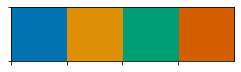

In [100]:
# Get those unique colors
if len(metadata.Channel.unique()) > 10:
    print("WARNING: There are more unique channel values than \
    there are colors to choose from. Select different palette, e.g., \
    continuous palette 'husl'.")
channel_color_values = sb.color_palette("colorblind",n_colors = len(metadata.Channel.unique()))#'HLS'
# chose 'colorblind' because it is categorical and we're unlikely to have > 10

print("Unique channels are:", metadata.Channel.unique())
# Display those unique colors
sb.palplot(sb.color_palette(channel_color_values))


Store in a dictionary

In [101]:
channel_color_dict = dict(zip(metadata.Channel.unique(), channel_color_values))

channel_color_dict

{'c2': (0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
 'c3': (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
 'c4': (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
 'c5': (0.8352941176470589, 0.3686274509803922, 0.0)}

Let's choose our channel colors instead. We can use the function `matplotlib.colors.to_rbg(c)`, where `c` is a word color name, to convert to the (r, g, b) tuple needed for the workflow. At the top of the script, we imported `matplotlib.colors` as `mplc`, so we can save time and type out simply `mplc.to_rgb(c)` shorthand when using this function. Note that if you use any of the xkcd color survey colors (https://xkcd.com/color/rgb/), you will need to call these specify these as 'xkcd:colorname'.

I will demonstrate a couple of different ways of doing changing the colors we generated above, so the user can expand on the examples as necessary. We are holding all of our color information in several instances of a data structure called a dictionary. https://docs.python.org/3/library/stdtypes.html#typesmapping

Dictionaries are a way to store an unordered collection of items where each is composed of a key-value mapped pair. In the case of this workflow, each color dictionary has a string identifying the specific thing to be colored, e.g., 'c2', 'TMA', 'cluster1', or 'r5', and the corresponding value is a three-float tuple (r, g, b) that is the color of that thing. With dictionaries, we can remove an key-value pair, add a new key-value pair, or overwrite an existing key-value pair whenever we want. Keys can be many things, but often you will see them as a string. Values can be strings, lists, other dictionaries (as seen below for the heatmaps), etc. Nested dictionaries can be complicated to intuit, but they can be a good way to associate a bunch of information together easily, coding-wise. Keys are not ordered within a dictionary.

In [102]:
# get a new color for a channel, overwrite/replace the original channel color in the dictionary

c2_color = "green"
c2_color = mplc.to_rgb("green")
print("Our new color in rbg form is " + str(c2_color) + ".")

print("Before replacement, c2 in the dictionary is: " + str(channel_color_dict['c2']))

# Replace value
channel_color_dict['c2'] = c2_color
print("After replacement, c2 in the dictionary is: " + str(channel_color_dict['c2']))

Our new color in rbg form is (0.0, 0.5019607843137255, 0.0).
Before replacement, c2 in the dictionary is: (0.00392156862745098, 0.45098039215686275, 0.6980392156862745)
After replacement, c2 in the dictionary is: (0.0, 0.5019607843137255, 0.0)


In [103]:
# Here is how you delete an item from a dictionary

print("Keys in the channel color dictionary are: " + str(channel_color_dict.keys()))

# If we try to remove an existing key, we will get an error
if 'c2' in channel_color_dict.keys():
    print("'c2' is in the dictionary. Removing now.")
    channel_color_dict.pop('c2')
    
print("Keys in the channel color dictionary are: " + str(channel_color_dict.keys()))

Keys in the channel color dictionary are: dict_keys(['c2', 'c3', 'c4', 'c5'])
'c2' is in the dictionary. Removing now.
Keys in the channel color dictionary are: dict_keys(['c3', 'c4', 'c5'])


In [104]:
## Add in a new item
print("Keys in the channel color dictionary are: " + str(channel_color_dict.keys()))
print("Adding in 'c2'...")
channel_color_dict['c2'] = c2_color
print("Keys in the channel color dictionary are: " + str(channel_color_dict.keys()))


Keys in the channel color dictionary are: dict_keys(['c3', 'c4', 'c5'])
Adding in 'c2'...
Keys in the channel color dictionary are: dict_keys(['c3', 'c4', 'c5', 'c2'])


In [105]:
## Let's finish the dictionary now

channel_color_dict['c2'] = mplc.to_rgb('green')
channel_color_dict['c3'] = mplc.to_rgb('orange')
channel_color_dict['c4'] = mplc.to_rgb('red')
channel_color_dict['c5'] = mplc.to_rgb('turquoise')

In [1]:
## And display the colors so we can see them

# Instead of querying the dictionary to get each of our colors, THEN putting those colors in a list,
# THEN feeding that list into the palplot/color_palette code as above, I will condense these steps
# together. Here we are accessing each (r,g,b) color value in the dictionary using the key.
print(['c2','c3','c4','c5'])
sb.palplot(sb.color_palette(
    [channel_color_dict['c2'],channel_color_dict['c3'],channel_color_dict['c4'],channel_color_dict['c5']]))


['c2', 'c3', 'c4', 'c5']


NameError: name 'sb' is not defined

#### Round colors

Round colors - want colors that are sequential, since Round is an ordered category. We can still generate colors that are easy to distinguish. Also, many of the categorical palettes cap at at about 10 or so unique colors, and repeat from there. We do not want any repeats!

['R0' 'R1' 'R2' 'R3' 'R4' 'R5' 'R6' 'R7']


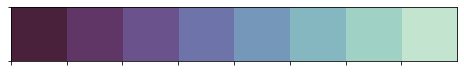

In [107]:
round_color_values = sb.cubehelix_palette(
    len(metadata.Round.unique()), start=1, rot= -0.75, dark=0.19, light=.85, reverse=True)
#round_color_values = sb.color_palette("cubehelix",n_colors = len(metadata.Round.unique()))
# chose 'cubehelix' because it is sequential, and round is a continuous process
# each color value is a tuple of three values: (R, G, B)
print(metadata.Round.unique())

sb.palplot(sb.color_palette(round_color_values))

## TO-DO: write what these parameters mean

Store in a dictionary

In [108]:
round_color_dict = dict(zip(metadata.Round.unique(), round_color_values))

for k,v in round_color_dict.items():
    round_color_dict[k] = np.float64(v)

#### Sample colors

Sample colors - want colors that are neither sequential nor categorical. Categorical would be ideal if we could generate an arbitrary number of colors, but I do not think that we can. Hense, we will choose `n` colors from a continuous palette. First we will generate the right number of colors. Later, we will assign TMA samples to gray.

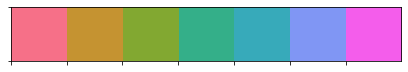

In [109]:
# Get those unique colors
color_values = sb.color_palette("husl",n_colors = len(ls_samples))#'HLS'
# each color value is a tuple of three values: (R, G, B)

# Display those unique colors
sb.palplot(sb.color_palette(color_values))

In [110]:
#sb.palplot((.5,.5,.5))

Generate enough gray shades for all TMA samples in dataset.

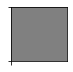

In [111]:
# Get list of all TMA samples
# by looking for substring 'TMA' in all unique Sample_ID values
TMA_samples = [s for s in df.Sample_ID.unique() if 'TMA' in s]

# Now make a list of unique gray shades,
# whose length equals the length of the list above
TMA_color_values = sb.color_palette(n_colors = len(TMA_samples),palette = "gray")

# Show the gray color(s) to the user
sb.palplot(sb.color_palette(TMA_color_values))

#### Store in a dictionary

In [112]:
# Now we will create a dictionary to hold this information
# Here we are mapping the unique Sample_ID values in df
# (note that sorted() ensures they are in alphabetical
# order) with the color_values list we derived above.
# This list does NOT have our TMA gray(s) in it.
# After we associate the two groups of items together
# with zip, we turn it into a dictonary: key = Sample_ID,
# value = color for that Sample_ID
sample_color_dict = dict(zip(
    sorted(df.Sample_ID.unique()), color_values
            ))

# Edit our dictioanry
# Replace all TMA samples' colors with gray by
# iterating through all keys in sorted order
# and replacing the color with a gray one. We are
# moving through our list of gray colors using our
# index 'i', so that each TMA gets a different gray.
i = 0
for key in sorted(sample_color_dict.keys()):
    if 'TMA' in key:
        sample_color_dict[key] = TMA_color_values[i]
        i +=1

In [113]:
sample_color_dict

{'GZ10.1': (0.9677975592919913, 0.44127456009157356, 0.5358103155058701),
 'GZ10.2': (0.775731904186273, 0.5784925270759935, 0.19475566538551872),
 'GZ10.3': (0.5105309046900421, 0.6614299289084904, 0.1930849118538962),
 'GZ6': (0.20433460114757862, 0.6863857739476534, 0.5407103379425205),
 'GZ7.1': (0.21662978923073606, 0.6676586160122123, 0.7318695594345369),
 'GZ7.2': (0.5049017849530067, 0.5909119231215284, 0.9584657252128558),
 'TMA': (0.5019607843137255, 0.5019607843137255, 0.5019607843137255)}

Look at the (r,g,b) values of the colors above. Any TMA sample should have r ~= g ~= b.

Display the colors:

Our samples and corresponding colors are:
['GZ10.1', 'GZ10.2', 'GZ10.3', 'GZ6', 'GZ7.1', 'GZ7.2', 'TMA']


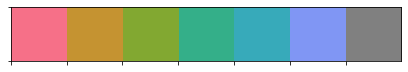

In [114]:
print("Our samples and corresponding colors are:")
print([key for key in sorted(sample_color_dict.keys())])
sb.palplot(sb.color_palette([sample_color_dict[key] for key in sorted(sample_color_dict.keys())]))

### Save color information (mapping and legend) to metadata directory

In [115]:
# let's look at the metadata again...
metadata.head()


,Round,Target,Exp,Channel,target_lower,full_column,marker,location
0,R0,AF488,300,c2,af488,AF488_Cell_Intensity_Average,AF488,cell
1,R0,AF555,1500,c3,af555,AF555_Cell_Intensity_Average,AF555,cell
2,R0,AF647,1500,c4,af647,AF647_Cell_Intensity_Average,AF647,cell
3,R0,AF750,1500,c5,af750,AF750_Cell_Intensity_Average,AF750,cell
4,R1,H3K27me3,200,c2,h3k27me3,H3K27me3_Cell_Intensity_Average,H3K27me3,cell


Add in the color information in both RGB (range 0-1) and hex values, for use in visualizations

In [116]:
metadata['round_color'] = metadata.apply(lambda row: round_color_dict[row['Round']], axis = 1)
metadata['channel_color'] = metadata.apply(lambda row: channel_color_dict[row['Channel']], axis = 1)

def color_dict_to_df(cd, column_name):
    df = pd.DataFrame.from_dict(cd, orient = 'index')
    df['rgb'] = df.apply(lambda row: (np.float64(row[0]), np.float(row[1]), np.float64(row[2])), axis = 1)
    df = df.drop(columns = [0,1,2])
    df['hex'] = df.apply(lambda row: mplc.to_hex(row['rgb']), axis = 1)
    df[column_name] = df.index
    return df

Sample

In [117]:
# Create dataframe
color_df = color_dict_to_df(sample_color_dict, "Sample_ID")
color_df.head()

# Save to file in metadatadirectory
filename = "sample_color_data.csv"
filename = os.path.join(metadata_dir, filename)
color_df.to_csv(filename, index = False)

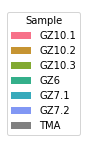

In [118]:
# Legend of sample info only

g  = plt.figure(figsize = (1,1)).add_subplot(111)
g.axis('off')
handles = []
for item in sample_color_dict.keys():
        h = g.bar(0,0, color = sample_color_dict[item],
                  label = item, linewidth =0)
        handles.append(h)
first_legend = plt.legend(handles=handles, loc='upper right', title = 'Sample'),
                            # bbox_to_anchor=(10,10), 
                             #       bbox_transform=plt.gcf().transFigure)

filename = "Sample_legend.png"
filename = os.path.join(metadata_images_dir, filename)
plt.savefig(filename, bbox_inches = 'tight')

Channel

In [119]:
# Create dataframe
color_df = color_dict_to_df(channel_color_dict, "Channel")
color_df.head()

# Save to file in metadatadirectory
filename = "channel_color_data.csv"
filename = os.path.join(metadata_dir, filename)
color_df.to_csv(filename, index = False)

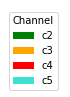

In [120]:
# Legend of channel info only

g  = plt.figure(figsize = (1,1)).add_subplot(111)
g.axis('off')
handles = []
for item in sorted(channel_color_dict.keys()):
        h = g.bar(0,0, color = channel_color_dict[item],
                  label = item, linewidth =0)
        handles.append(h)
first_legend = plt.legend(handles=handles, loc='upper right', title = 'Channel'),
                            # bbox_to_anchor=(10,10), 
                             #       bbox_transform=plt.gcf().transFigure)

filename = "Channel_legend.png"
filename = os.path.join(metadata_images_dir, filename)
plt.savefig(filename, bbox_inches = 'tight')

Round

In [121]:
# Create dataframe
color_df = color_dict_to_df(round_color_dict, "Round")
color_df.head()

# Save to file in metadatadirectory
filename = "round_color_data.csv"
filename = os.path.join(metadata_dir, filename)
color_df.to_csv(filename, index = False)

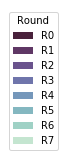

In [122]:
# Legend of round info only

round_legend  = plt.figure(figsize = (1,1)).add_subplot(111)
round_legend.axis('off')
handles = []
for item in round_color_dict.keys():
        h = round_legend.bar(0,0, color = round_color_dict[item],
                  label = item, linewidth =0)
        handles.append(h)
first_legend = plt.legend(handles=handles, loc='upper right', title = 'Round'),
                            # bbox_to_anchor=(10,10), 
                             #       bbox_transform=plt.gcf().transFigure)

filename = "Round_legend.png"
filename = os.path.join(metadata_images_dir, filename)
plt.savefig(filename, bbox_inches = 'tight')

## Initial heatmap

We will only be plotting ~10k cells in the interest of time/computing resources. We want these 10k lines in our original df to be sampled randomly, without replacement, with the caveat that the proportions of all samples in the data remains the same in this subset. If the size of the dataframe is > 10k rows, then we will proceed with the entire dataset.

In [123]:
heatmap_row_count = min(10000, df.shape[0])

In [155]:
# Create df of each feature type, its proportion in the full df,
# and the number of rows we want for a sum of heatmap_row_count rows
counts_for_heatmap = create_equal_value_counts(df, 'Sample_ID',heatmap_row_count)
counts_for_heatmap

,current_row_count,prop,desired_row_count
GZ10.1,3976,0.010011,1429
GZ10.2,3773,0.009500,1429
GZ10.3,9597,0.024164,1429
GZ6,61409,0.154621,1429
GZ7.1,19788,0.049824,1429
GZ7.2,155181,0.390729,1429
TMA,143434,0.361151,1429


In [156]:
# Create new df to hold our heatmap data
heatmap_data = pd.DataFrame(columns = df.columns)

# populate the df
for sample in df.Sample_ID.unique():
    a = counts_for_heatmap.loc[counts_for_heatmap.index == sample,'current_row_count'].values[0]
    size = counts_for_heatmap.loc[counts_for_heatmap.index == sample,'desired_row_count'].values[0]
    random_rows = np.random.choice(a = a, size = size, replace = False)
    df_sample = df.loc[df['Sample_ID'] == sample,:]
    heatmap_data = heatmap_data.append(df_sample.iloc[random_rows,:])
    #random_rows = np.random.choice(heatmap_samples.loc[sample,values])
    #heatmap_data = heatmap_data.append()

In [157]:
## We want to make sure our sampling worked as expected.

# In our new dataframe, how many rows do we actually have for each sample?
# What is the proportion of each sample's rows of the total dataframe?

# Compare this with the 'counts_for_heatmap' above
# Note there might be slight differences in 'prop' due to rounding


create_equal_value_counts(heatmap_data, 'Sample_ID', heatmap_data.shape[0])

,current_row_count,prop,desired_row_count
GZ10.1,1429,0.142857,1429
GZ10.2,1429,0.142857,1429
GZ10.3,1429,0.142857,1429
GZ6,1429,0.142857,1429
GZ7.1,1429,0.142857,1429
GZ7.2,1429,0.142857,1429
TMA,1429,0.142857,1429


Get data structures to map colors to columns and rows...

In [256]:
row_sample_colors = heatmap_data.Sample_ID.map(sample_color_dict)

row_sample_colors[1:5]

GZ7.2_Cell_6771      (0.5049017849530067, 0.5909119231215284, 0.958...
GZ7.2_Cell_52885     (0.5049017849530067, 0.5909119231215284, 0.958...
GZ7.2_Cell_59038     (0.5049017849530067, 0.5909119231215284, 0.958...
GZ7.2_Cell_148895    (0.5049017849530067, 0.5909119231215284, 0.958...
Name: Sample_ID, dtype: object

In [257]:
column_channel_colors = pd.merge(pd.DataFrame(pd.Series(
    heatmap_data.loc[:,~heatmap_data.columns.isin(not_intensities)].columns.values)), 
                  metadata, how = 'left',
         left_on = 0, right_on = 'full_column')[[0,'Channel']]['Channel'].map(channel_color_dict)


column_channel_colors.index = heatmap_data.loc[:,~heatmap_data.columns.isin(not_intensities)].columns.values

column_channel_colors.head()

53BP1_Cell_Intensity_Average    (0.25098039215686274, 0.8784313725490196, 0.81...
AF488_Cell_Intensity_Average                       (0.0, 0.5019607843137255, 0.0)
AF555_Cell_Intensity_Average                                      (1.0, 0.0, 0.0)
AF647_Cell_Intensity_Average                       (1.0, 0.6470588235294118, 0.0)
AF750_Cell_Intensity_Average    (0.25098039215686274, 0.8784313725490196, 0.81...
Name: Channel, dtype: object

In [258]:
column_round_colors = pd.merge(pd.DataFrame(pd.Series(
    heatmap_data.loc[:,~heatmap_data.columns.isin(not_intensities)].columns.values)), 
                  metadata, how = 'left',
         left_on = 0, right_on = 'full_column')[[0,'Round']]['Round'].map(round_color_dict)


column_round_colors.index = heatmap_data.loc[:,~heatmap_data.columns.isin(not_intensities)].columns.values

column_round_colors.head()

53BP1_Cell_Intensity_Average    [0.3736023974468758, 0.214424058315835, 0.3978...
AF488_Cell_Intensity_Average    [0.28685356234627135, 0.13009829239513535, 0.2...
AF555_Cell_Intensity_Average    [0.28685356234627135, 0.13009829239513535, 0.2...
AF647_Cell_Intensity_Average    [0.28685356234627135, 0.13009829239513535, 0.2...
AF750_Cell_Intensity_Average    [0.28685356234627135, 0.13009829239513535, 0.2...
Name: Round, dtype: object

In [259]:
# Create data structure to hold everything we need for row/column annotations
# annotations is a dictionary
## IMPORTANT - if you use 'annotations', it MUST have both 'rows' and 'cols'
## objects inside. These can be empty lists, but they must be there!
annotations = {}

# create a data structure to hold everything we need for only row annotations
# row_annotations is a list, where each item therein is a dictioary corresponding
# to all of the data pertaining to that particular annotation
# Adding each item (e.g., Sample, then Cluster), one at a time to ensure ordering
# is as anticipated on figure
row_annotations = []
row_annotations.append({'label':'Sample','type':'row','mapping':row_sample_colors,'dict':sample_color_dict,
                        'location':'center left','bbox_to_anchor':(0, 0.5)})
# Add all row information into the annotations dictionary
annotations['rows'] = row_annotations


# Now we repeat the process for column annotations
col_annotations = []
col_annotations.append({'label':'Round','type':'column','mapping':column_round_colors,'dict':round_color_dict,
                       'location':'upper right','bbox_to_anchor':(1,0.50)})

col_annotations.append({'label':'Column','type':'column','mapping':column_channel_colors,'dict':channel_color_dict,
                       'location':'upper right','bbox_to_anchor':(1,0.75)})
annotations['cols'] = col_annotations

#### Actually plot the heatmap

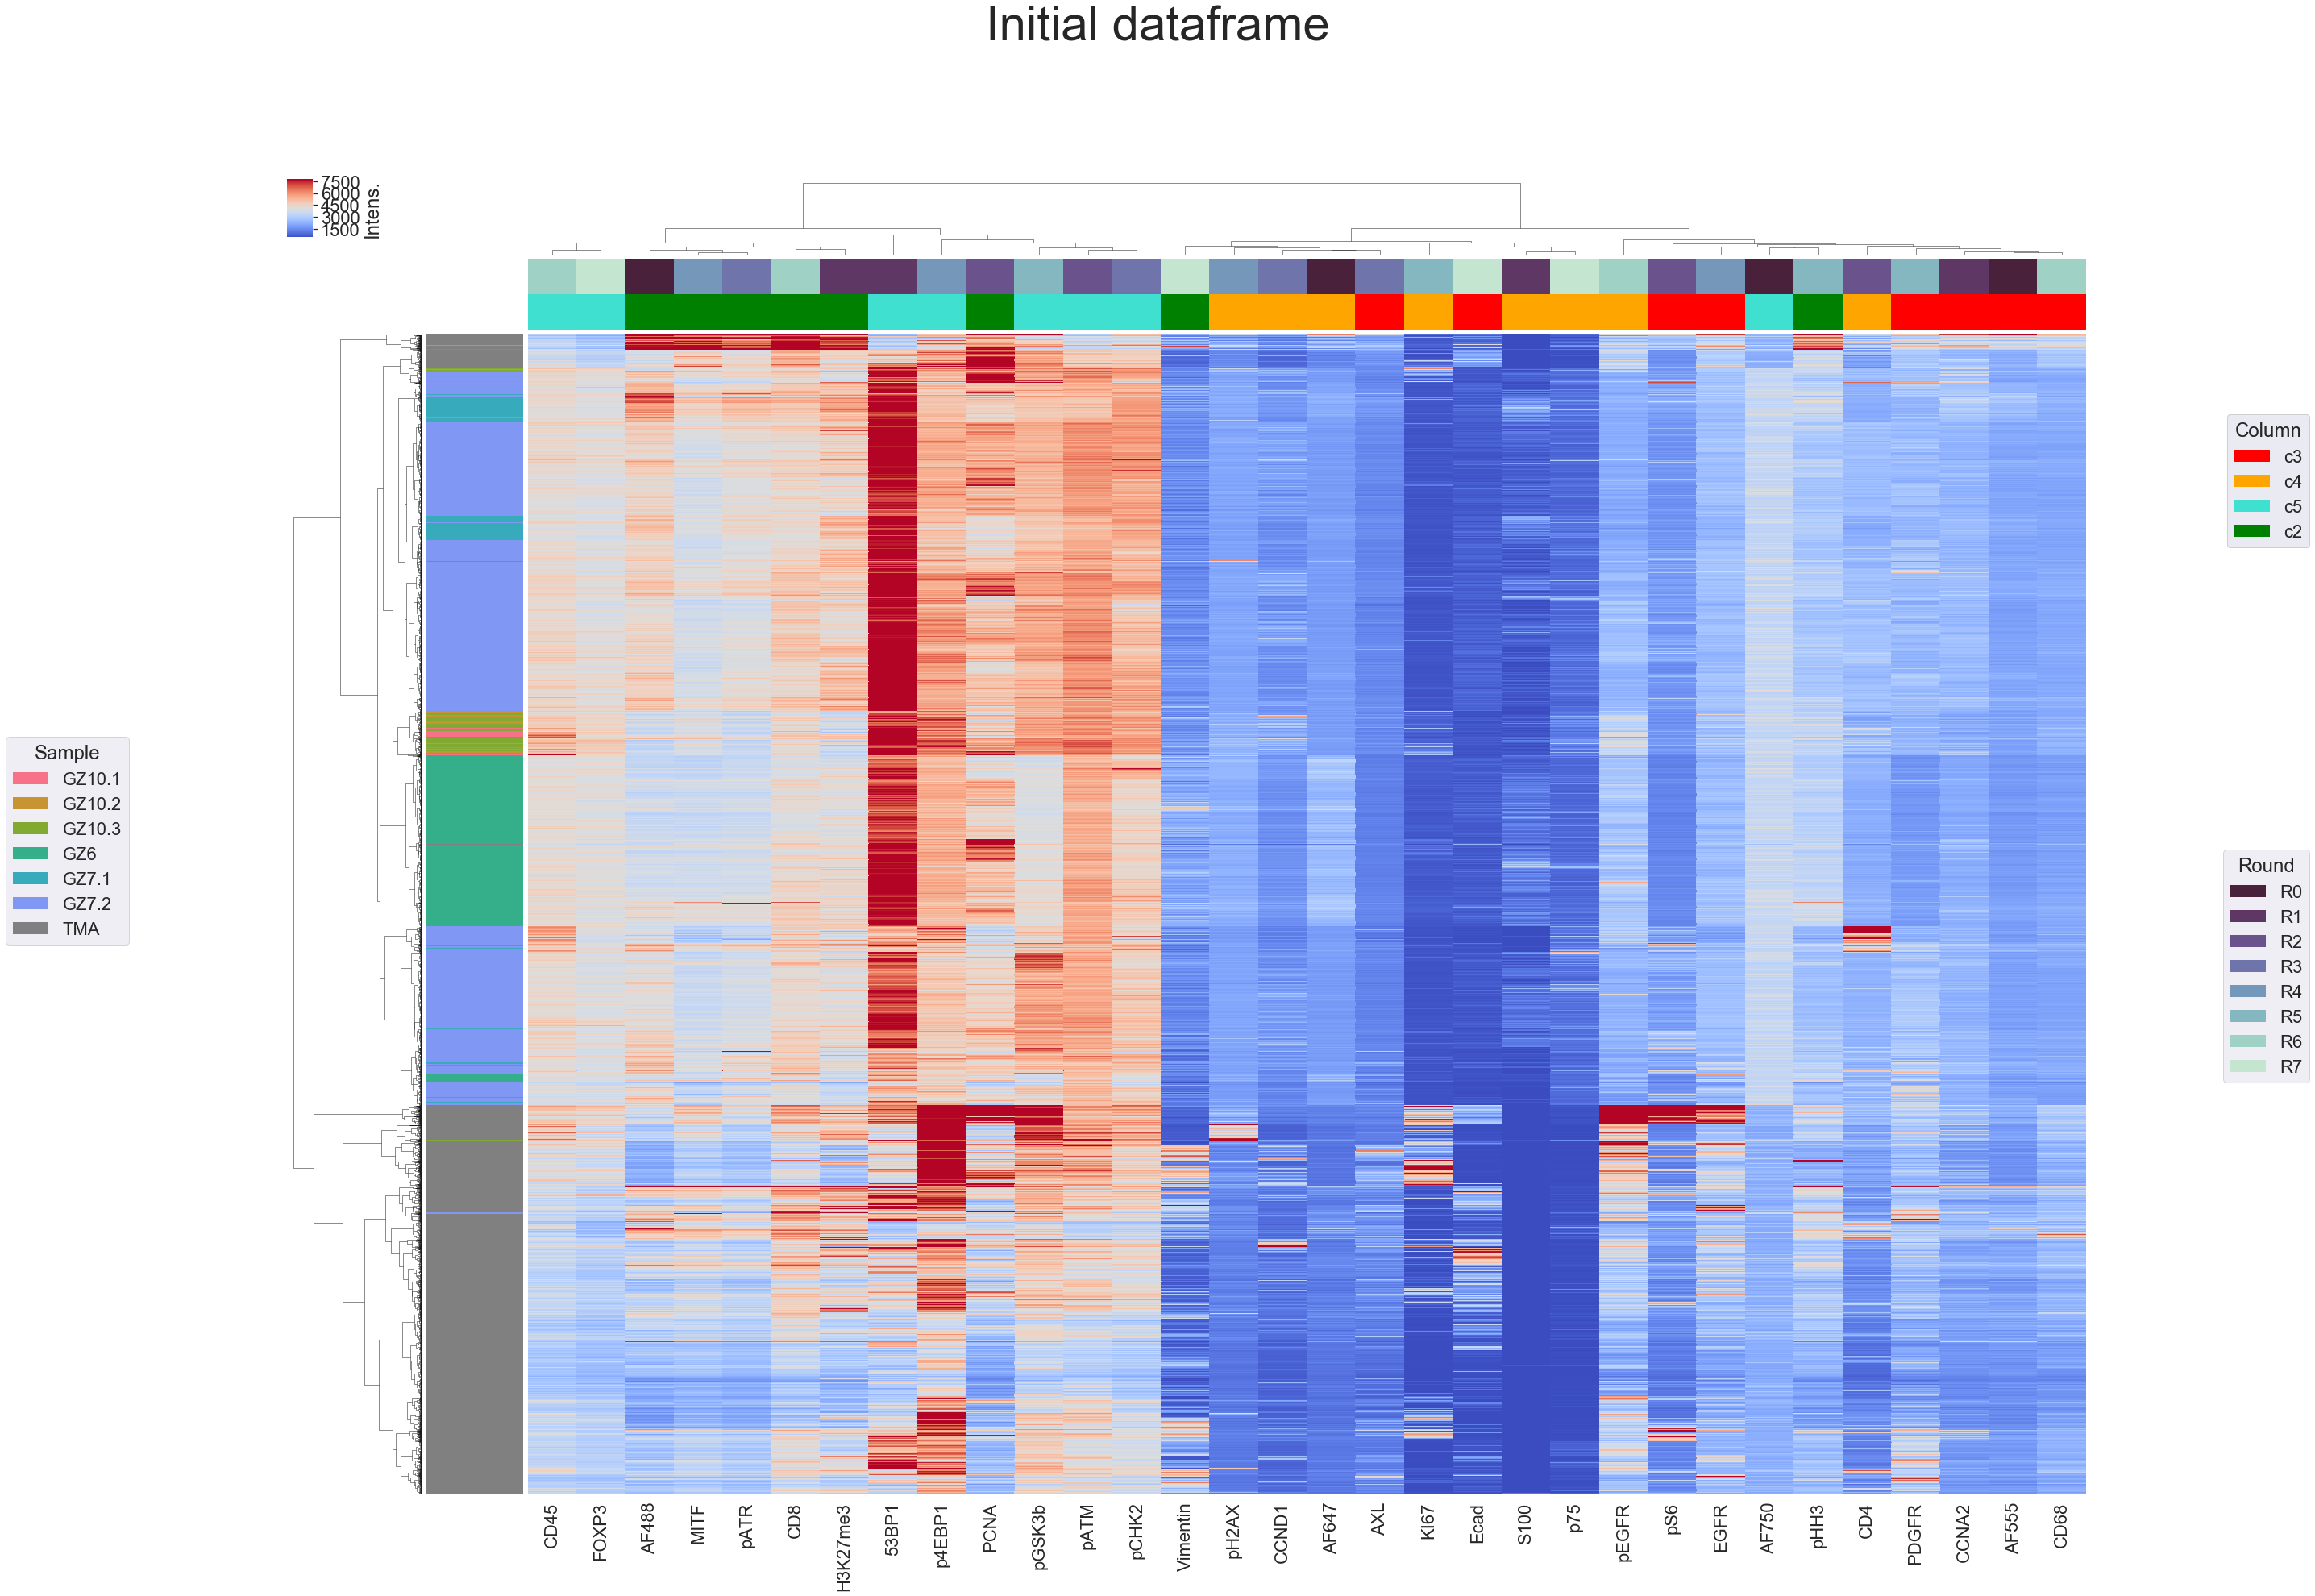

In [260]:
heatmap_function(data = heatmap_data.loc[:,~heatmap_data.columns.isin(not_intensities)],
    title = "Initial dataframe",
               # define method, metric, and color map
          method = 'ward', metric = 'euclidean',cmap = 'coolwarm',
               # colorbar (legend coloring of main plot) 
               cbar_kws = {'label':'Intens.'},
               # xticklabels - want to have the nicknames instead of full names
    xticklabels = [full_to_short_names[name] for name in 
                     heatmap_data.loc[:,
                                 ~heatmap_data.columns.isin(not_intensities)].columns.values],
                 save_loc = output_images_dir,
                 row_cluster = True, col_cluster = True,
                    annotations = annotations
          )

### Bar plot of count of all cells in all samples - no filtering yet

In [262]:
# Get counts for each Sample_ID, sorted by Sample_ID
counts = pd.DataFrame(df.Sample_ID.value_counts()).sort_index()
counts = counts.rename(columns = {'Sample_ID':'counts'})
counts['Sample_ID'] = counts.index
counts['color'] = counts.apply(lambda row: sample_color_dict[row['Sample_ID']], axis = 1)
counts.head()

,counts,Sample_ID,color
GZ10.1,3976,GZ10.1,"(0.9677975592919913, 0.44127456009157356, 0.53..."
GZ10.2,3773,GZ10.2,"(0.775731904186273, 0.5784925270759935, 0.1947..."
GZ10.3,9597,GZ10.3,"(0.5105309046900421, 0.6614299289084904, 0.193..."
GZ6,61409,GZ6,"(0.20433460114757862, 0.6863857739476534, 0.54..."
GZ7.1,19788,GZ7.1,"(0.21662978923073606, 0.6676586160122123, 0.73..."


In [263]:
ls_samples

['GZ7.2', 'TMA', 'GZ10.3', 'GZ7.1', 'GZ10.2', 'GZ10.1', 'GZ6']

In [265]:
# By sample ID only

fig = go.Figure()
title = 'Initial Cell counts by Sample ID'

# Changing the ordering of the bars is a easy as iterating through a list
# with the samples in a different order! For example, this order below:
#for sample in ['TMA', 'GZ7.2', 'GZ10.3', 'GZ7.1', 'GZ10.2', 'GZ10.1', 'GZ6']:
for sample in ls_samples:
    fig.add_trace(go.Bar(
        x=counts.loc[counts['Sample_ID']==sample,'Sample_ID'], 
        y = counts.loc[counts['Sample_ID']==sample,'counts'],
        text = counts.loc[counts['Sample_ID']==sample,'counts'], 
        textposition='outside',
        marker=dict(
            color='rgb' + str(sample_color_dict[sample])),
            showlegend = False
        
    ))
    
    
fig.update_layout(title = title, plot_bgcolor = 'white')
fig.update_xaxes(title_text = "Sample ID", linecolor = 'black')
fig.update_yaxes(title_text = "Cell count", linecolor = 'black')

#plot(fig)
filename = os.path.join(output_images_dir, title.replace(" ","_") + ".png")
fig.write_image(filename)


In [267]:
## for PCA
filename = "weewin_PCA_test.csv"
filename = "repro_PCA_test.csv"
filename = "gz_PCA_test.csv"
#df.to_csv(filename, index = False)
#os.getcwd()

### Drop any other rows or columns we want to before saving data

In [268]:
# Let's take a look
df.columns.values

array(['Nuc_X_Inv', 'Nuc_Y', 'ROI_index', 'Nuc_Y_Inv', 'Nuc_X',
       'Nucleus_Size', 'Sample_ID', 'Cell_Size',
       '53BP1_Cell_Intensity_Average', 'AF488_Cell_Intensity_Average',
       'AF555_Cell_Intensity_Average', 'AF647_Cell_Intensity_Average',
       'AF750_Cell_Intensity_Average', 'AXL_Cell_Intensity_Average',
       'CCNA2_Cell_Intensity_Average', 'CCND1_Cell_Intensity_Average',
       'CD45_Cell_Intensity_Average', 'CD4_Cell_Intensity_Average',
       'CD68_Cell_Intensity_Average', 'CD8_Cell_Intensity_Average',
       'EGFR_Cell_Intensity_Average', 'Ecad_Cell_Intensity_Average',
       'FOXP3_Cell_Intensity_Average', 'H3K27me3_Cell_Intensity_Average',
       'KI67_Cell_Intensity_Average', 'MITF_Cell_Intensity_Average',
       'PCNA_Cell_Intensity_Average', 'PDGFR_Cell_Intensity_Average',
       'S100_Cell_Intensity_Average', 'Vimentin_Cell_Intensity_Average',
       'p4EBP1_Cell_Intensity_Average', 'p75_Cell_Intensity_Average',
       'pATM_Cell_Intensity_Average', 'pATR_

For the sake of example, I will operate on a copy of df, called df_copy

In [269]:
# You MUST do df.copy()
# 'df_copy = df' would essentially 
# give you two different names for the
# SAME dataframe, so operating on one
# would also operate on the other
df_copy = df.copy()

#### Operate on entire rows or columns

In [270]:
# Drop columns
my_cols = []
df_copy = df_copy.drop(columns = my_cols)

In [ ]:
# Keep only specific columns (explained below)
my_cols = []
my_cols = df.columns.values
df_copy = df_copy.loc[:,my_cols]


#### Operate on rows and columns using filtering criteria

In [ ]:
# Keep only certain rows based off of criteria

# use df.loc[] to filter
# df.loc[rows,columns]
# df.loc[:,certain_cols] --> keep all rows ':', only certain cols
# df.loc[certain_rows,:] --> keep only certain row, all cols ':'

# Say we only want certain values for Sample_ID
print(df_copy.Sample_ID.unique())
keep = ['TMA','GZ6']
#keep = ['TMA1.1','TMA1.2','TMA1.3','TMA2.1','TMA2.2','TMA2.3']
df_copy = df_copy.loc[df_copy['Sample_ID'].isin(keep),:]
print(df_copy.Sample_ID.unique())

In [ ]:
# Filter on multiple criteria
# '&' or 'and'
# '|' or 'or'
# you MUST have parentheses around each logic expression!
df_copy = df_copy.loc[
    (df_copy['Sample_ID'].isin(['TMA1.1','TMA1.2','TMA1.3'])) \
    ## backslash above used to break line for readability, but tell Python to act like it's all one line
        | (df_copy['Sample_ID'].isin(['TMA2.1','TMA2.2','TMA2.3'])) , :]
print(df_copy.Sample_ID.unique())

In [ ]:
# Remove rows based off of certain criteria
# note the negating tilde '~'!

df_copy = df_copy.loc[
    (~df_copy['Sample_ID'].isin(['TMA1.1','TMA1.2','TMA1.3'])) \
    ## backslash above used to break line for readability, but tell Python to act like it's all one line
        & (~df_copy['Sample_ID'].isin(['TMA2.1','TMA2.2','TMA2.3'])),:]
print(df_copy.Sample_ID.unique())

## include example for cell types: cancer, stroma, immune

### Save the data by Sample_ID

In [271]:
# Check for existence of output file first
for sample in ls_samples:
    filename = os.path.join(output_data_dir,  sample + "_" + step_suffix + ".csv")
    if os.path.exists(filename):
        print("File by name "+filename+" already exists.")

In [273]:
# Save output files
for sample in ls_samples:
    df_save = df.loc[df['Sample_ID'] == sample,:]
    filename = os.path.join(output_data_dir,  sample + "_" + step_suffix + ".csv")
    df_save.to_csv(filename, index = True)
